In [189]:
import pandas as pd
import numpy as np

In [190]:
import warnings
warnings.filterwarnings('ignore')

In [191]:
USE_PCA = False


# note on some seeds lasso shuffled performs really well, but most of yhe time its just slightly better than the avrg bechmark
np.random.seed(seed=69)

In [175]:
# helper func

if USE_PCA:
    pca_prefix = 'pca50_'
    pca_sufix = '_pca'
else:
    pca_prefix = ''
    pca_sufix = ''

df = pd.read_csv(f'datasets/train_set{pca_sufix}.csv')
test_df = pd.read_csv(f'datasets/test_set{pca_sufix}.csv')

if USE_PCA:
    X = df.loc[:, 'pca_0':'pca_50']
else:
    X = df.loc[:, 'month':]
    
y = df['cpi_pct']
X_shuffled = df.sample(frac=1).loc[:, X.columns]
X_test = test_df.loc[:, X.columns]

In [176]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression

In [177]:
def save_coefs(model, name='blank'):
    coefs = np.concatenate([[model.intercept_], model.coef_])
    feature_names = ['Intercept'] + list(model.feature_names_in_)

    pd.DataFrame(coefs, index=feature_names, columns=['coefs']).to_csv(f'models/coefs/{pca_prefix}{name}_coefs.csv')

# Build OLS

In [178]:
model = LinearRegression()

model.fit(X, y)

pred = model.predict(X_test)

pd.DataFrame(pred, index=X_test.index, columns=['pred']).to_csv(f'predictions/{pca_prefix}ols.csv') 


save_coefs(model, 'ols')

# Build Lasso Model with 10 fold CV

In [179]:
model = Lasso(max_iter=3000)

params = {
    'alpha': np.logspace(-8, -0.5, 100).tolist()
}

cv = GridSearchCV(model, params, cv=10)
cv.fit(X, y)

print(cv.best_estimator_)

pred = cv.predict(X_test)

pd.DataFrame(pred, index=X_test.index, columns=['pred']).to_csv(f'predictions/{pca_prefix}lasso_cv.csv')

lasso = cv.best_estimator_

save_coefs(cv.best_estimator_, 'lasso_cv')

Lasso(alpha=0.0002477076355991714, max_iter=3000)


# Build Ridge Model with 10 fold CV

In [180]:
model = Ridge()

params = {
    'alpha': np.linspace(1, 10000, 100).tolist()
}

cv = GridSearchCV(model, params, cv=10)
cv.fit(X, y)

print(cv.best_estimator_)

pred = cv.predict(X_test)

pd.DataFrame(pred, index=X_test.index, columns=['pred']).to_csv(f'predictions/{pca_prefix}ridge_cv.csv')

save_coefs(cv.best_estimator_, 'ridge_cv')

Ridge(alpha=506.0)


# Lasso on shuffled Train Data

In [182]:
model = Lasso(max_iter=3000)

params = {
    'alpha': np.logspace(-8, -0.5, 100).tolist()
}

cv = GridSearchCV(model, params, cv=10)
cv.fit(X_shuffled, y)

print(cv.best_estimator_)

pred = cv.predict(X_test)

pd.DataFrame(pred, index=X_test.index, columns=['pred']).to_csv(f'predictions/{pca_prefix}lasso_cvshuffled.csv')

save_coefs(cv.best_estimator_, 'lasso_cvshuffled')

Lasso(alpha=0.0002949150729647068, max_iter=3000)


# Plotting Model Predictions

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for a nicer color palette

# Set a seaborn style
sns.set(style="whitegrid")

# Deep, muted, and bright are good choices for a color palette
colors = sns.color_palette("deep")

In [184]:
whole_data = pd.read_pickle('datasets/whole_dataset.pkl')

In [185]:
whole_data['BMA_prediction'] = lasso.predict(whole_data.loc[:, X.columns])

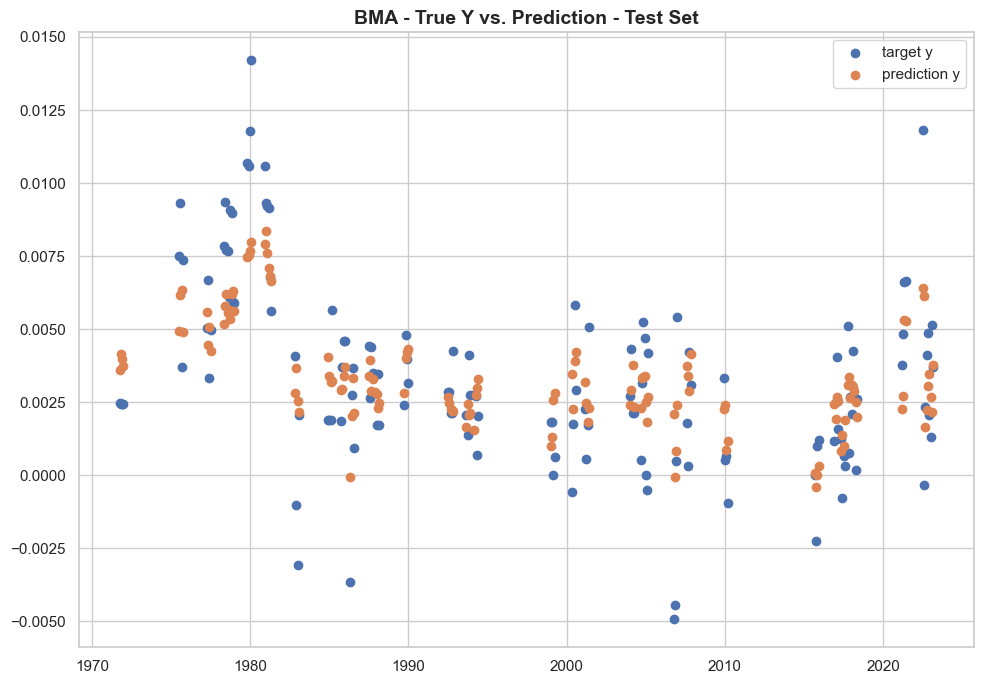

In [186]:
plot_data = whole_data[whole_data.test == True]


# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

# Plot the first graph on the left
axs.scatter(plot_data.index, plot_data['cpi_pct'], color=colors[0], label='target y')
axs.scatter(plot_data.index, plot_data['BMA_prediction'], color=colors[1], label='prediction y')
axs.set_title('BMA - True Y vs. Prediction - Test Set', fontsize=14, fontweight='bold')
axs.legend()
axs.grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.savefig('plots/predictions_test.png', dpi=300)

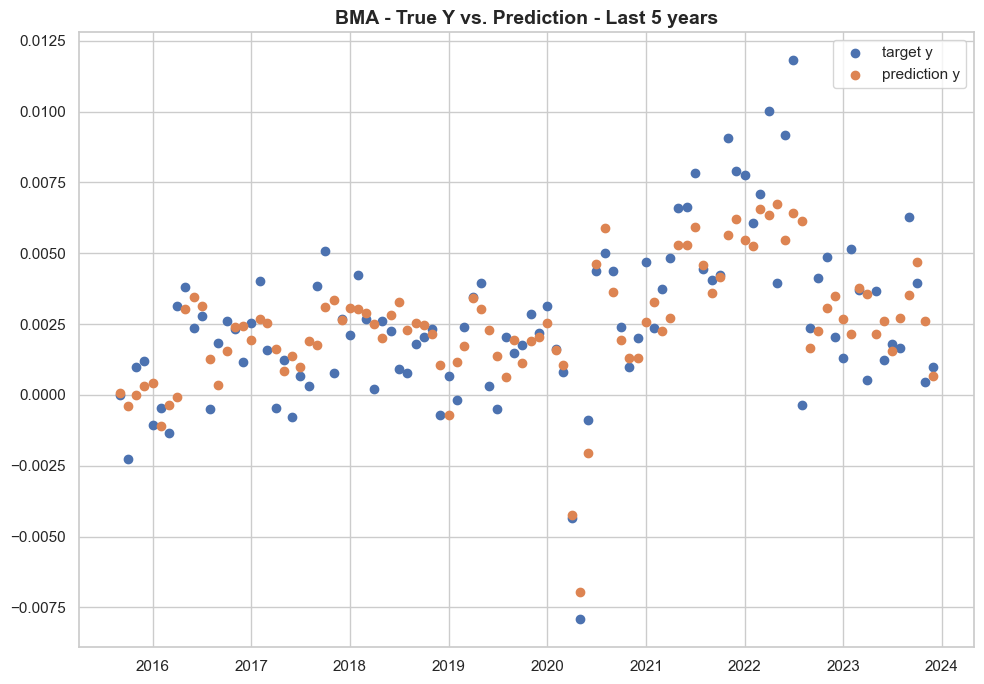

In [187]:
plot_data = whole_data.iloc[-100:, :]


# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

# Plot the first graph on the left
axs.scatter(plot_data.index, plot_data['cpi_pct'], color=colors[0], label='target y')
axs.scatter(plot_data.index, plot_data['BMA_prediction'], color=colors[1], label='prediction y')
axs.set_title('BMA - True Y vs. Prediction - Last 5 years', fontsize=14, fontweight='bold')
axs.legend()
axs.grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
# plt.savefig('plots/predictions_5years.png', dpi=300)

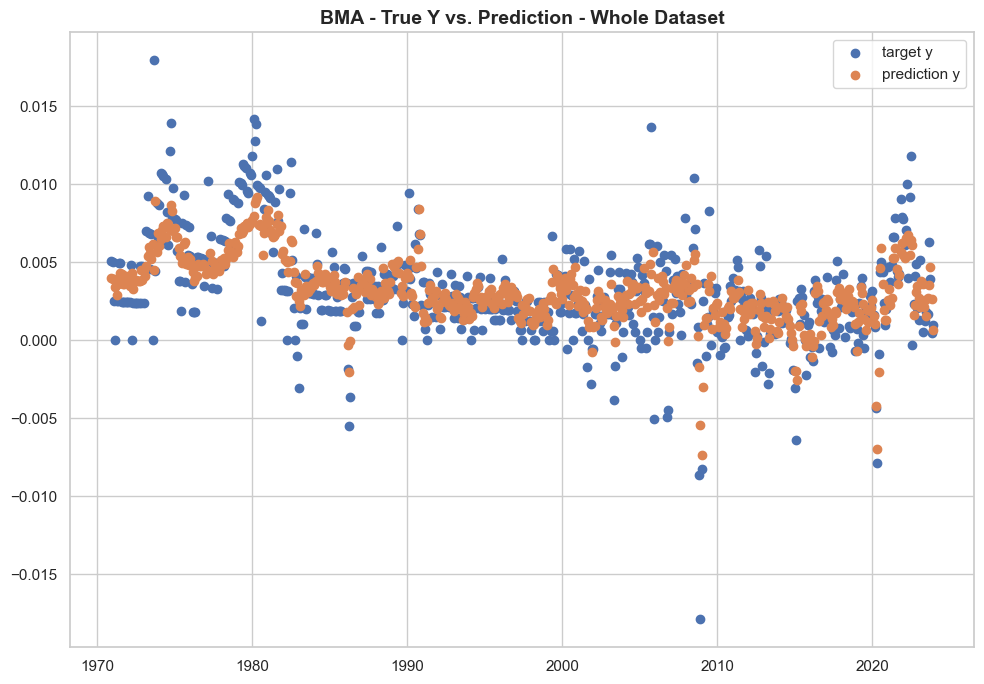

In [188]:
plot_data = whole_data


# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

# Plot the first graph on the left
axs.scatter(plot_data.index, plot_data['cpi_pct'], color=colors[0], label='target y')
axs.scatter(plot_data.index, plot_data['BMA_prediction'], color=colors[1], label='prediction y')
axs.set_title('BMA - True Y vs. Prediction - Whole Dataset', fontsize=14, fontweight='bold')
axs.legend()
axs.grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
# plt.savefig('plots/predictions_all_data.png', dpi=300)